## 물류 유통량 예측 경진대회

### 1. 배경
택배 운송량을 예측하여 비대면 경제의 발전을 예측하기 위한 경진대회를 개최합니다(사례지역:제주도).

### 2. 목적
제주시 내 택배 운송 데이터를 이용하여 운송량 예측 AI 개발

### [데이터]
* index : 인덱스
* SEND_SPG_INNB : 송하인_격자공간고유번호
* REC_SPG_INNB : 수하인 격자공간고유번호
* DL_GD_LCLS_NM : 카테고리_대
* DL_GD_MCLS_NM : 카테고리_중
* INVC_CONT : 운송장 건 수

*데이터 수집 시점 : 20년 01월

In [55]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import torch
from torch import nn
from pytorch_tabnet.tab_model  import TabNetRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
#from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

plt.rcParams['font.family'] = 'Malgun Gothic'

In [2]:
train_df = pd.read_csv('data/train_df.csv', encoding='euc-kr')
test_df = pd.read_csv('data/test_df.csv', encoding='euc-kr')

submission = pd.read_csv('data/sample_submission.csv')

In [3]:
train_df.head()

,index,SEND_SPG_INNB,REC_SPG_INNB,DL_GD_LCLS_NM,DL_GD_MCLS_NM,INVC_CONT
0,0,1129000014045300,5011000220046300,패션의류,상의,3
1,1,1135000009051200,5011000178037300,생활/건강,반려동물,3
2,2,1135000030093100,5011000265091400,패션의류,기타패션의류,9
3,3,1154500002014200,5011000315087400,식품,농산물,10
4,4,1165000021008300,5011000177051200,식품,가공식품,3


In [4]:
test_df.head()

,index,SEND_SPG_INNB,REC_SPG_INNB,DL_GD_LCLS_NM,DL_GD_MCLS_NM
0,32000,5013000043028400,1165000021097200,식품,농산물
1,32001,5013000044016100,1154500002066400,식품,농산물
2,32002,5013000205030200,4139000102013200,식품,농산물
3,32003,5013000205030200,4221000040093400,식품,농산물
4,32004,5013000268011400,2726000004017100,식품,농산물


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32000 entries, 0 to 31999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   index          32000 non-null  int64 
 1   SEND_SPG_INNB  32000 non-null  int64 
 2   REC_SPG_INNB   32000 non-null  int64 
 3   DL_GD_LCLS_NM  32000 non-null  object
 4   DL_GD_MCLS_NM  32000 non-null  object
 5   INVC_CONT      32000 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 1.5+ MB


In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4640 entries, 0 to 4639
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   index          4640 non-null   int64 
 1   SEND_SPG_INNB  4640 non-null   int64 
 2   REC_SPG_INNB   4640 non-null   int64 
 3   DL_GD_LCLS_NM  4640 non-null   object
 4   DL_GD_MCLS_NM  4640 non-null   object
dtypes: int64(3), object(2)
memory usage: 181.4+ KB


In [7]:
train_df.isnull().sum()

index            0
SEND_SPG_INNB    0
REC_SPG_INNB     0
DL_GD_LCLS_NM    0
DL_GD_MCLS_NM    0
INVC_CONT        0
dtype: int64

In [8]:
for col in train_df.columns:
    print(col)
    print(train_df[col].value_counts())
    print()

index
2047     1
21824    1
17698    1
19747    1
29988    1
        ..
15026    1
12979    1
2740     1
693      1
0        1
Name: index, Length: 32000, dtype: int64

SEND_SPG_INNB
5011000078068400    4227
5013000610049100    1994
5013000731055200    1335
5011000137030100    1206
5013000821028200     773
                    ... 
5011000263040400       1
5011000595029400       1
4833000396037100       1
5011000172003300       1
2623000016044400       1
Name: SEND_SPG_INNB, Length: 3684, dtype: int64

REC_SPG_INNB
5011000543041100    31
5011000596012200    27
5013000635005300    24
5011000544072300    20
5011000318044100    20
                    ..
4615000058100300     1
4413300195016200     1
4827000664030200     1
1168000027057100     1
2726000056072100     1
Name: REC_SPG_INNB, Length: 27826, dtype: int64

DL_GD_LCLS_NM
식품        27738
생활/건강      2020
여행/문화      1192
패션의류        582
디지털/가전      241
화장품/미용      227
Name: DL_GD_LCLS_NM, dtype: int64

DL_GD_MCLS_NM
농산물          22162


--------------------------------------------------
col :  DL_GD_LCLS_NM


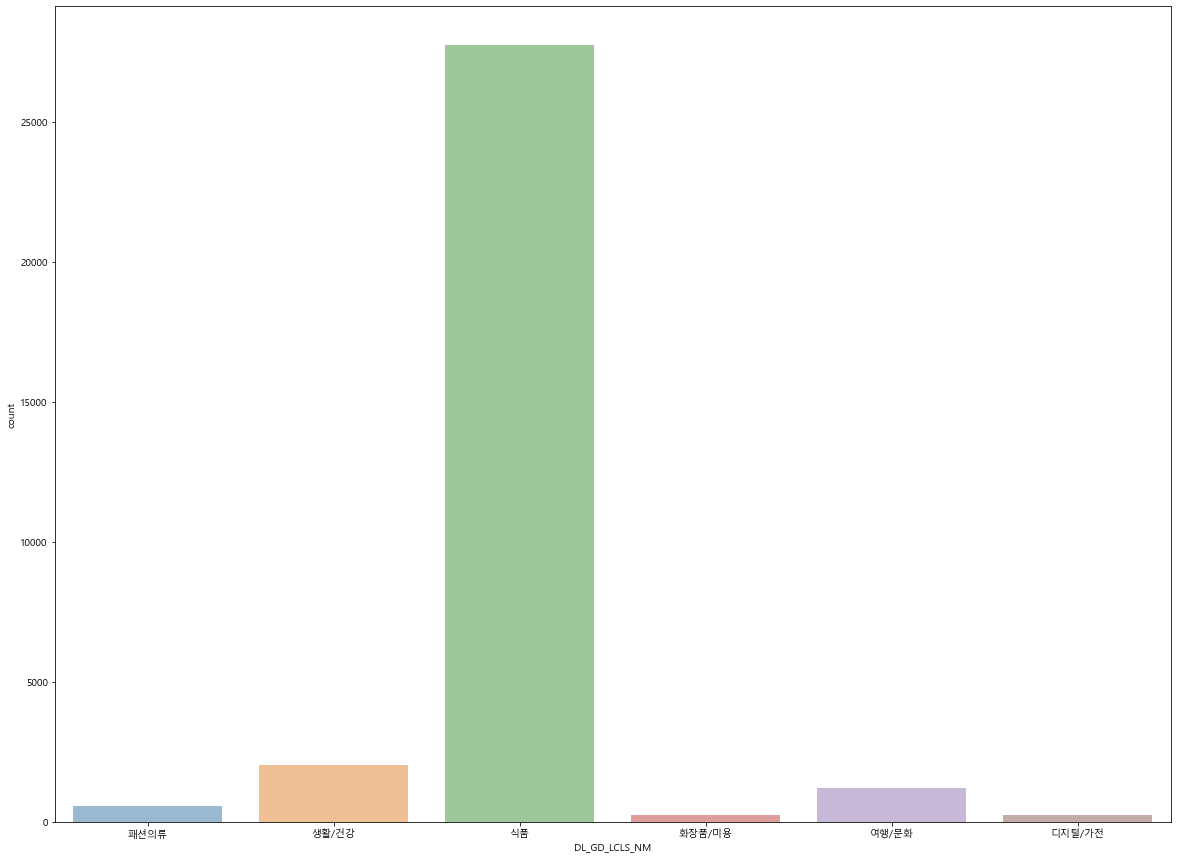

--------------------------------------------------
col :  DL_GD_MCLS_NM


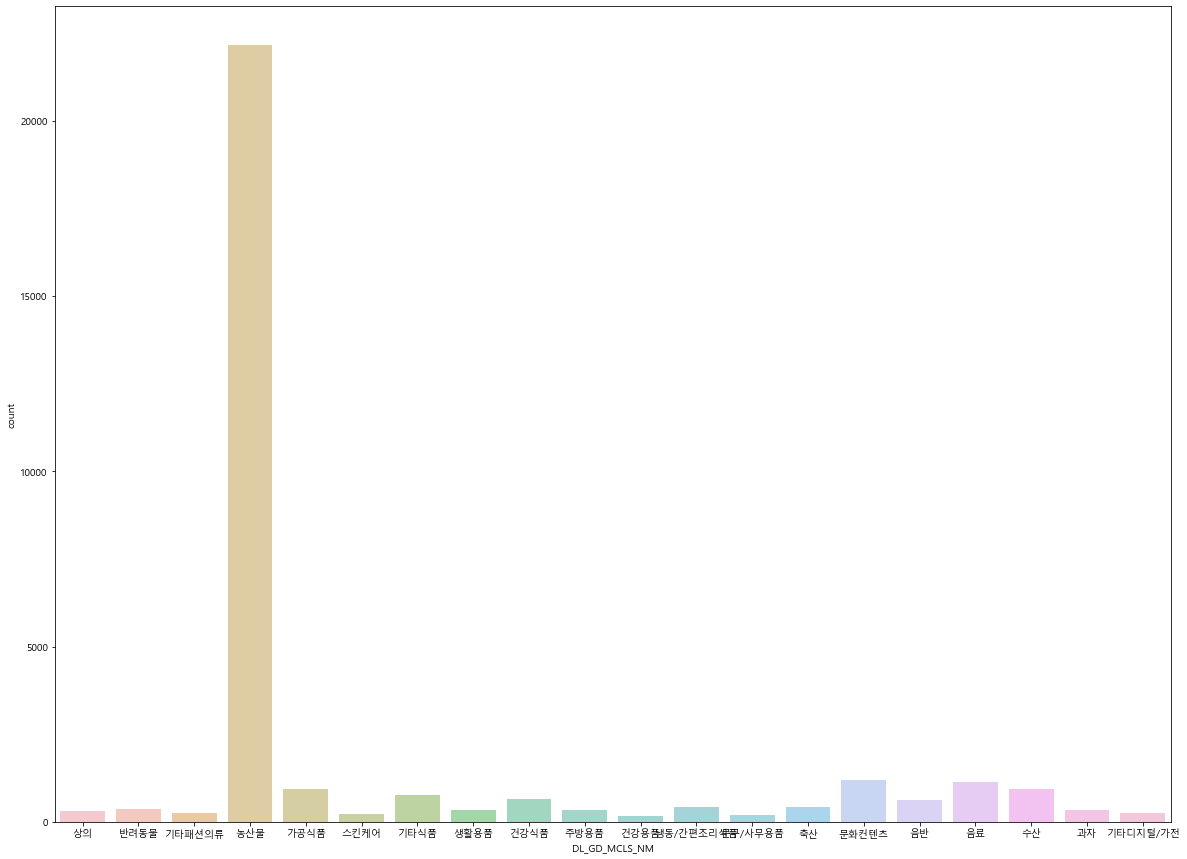

--------------------------------------------------
col :  INVC_CONT


C:\Users\donguk\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


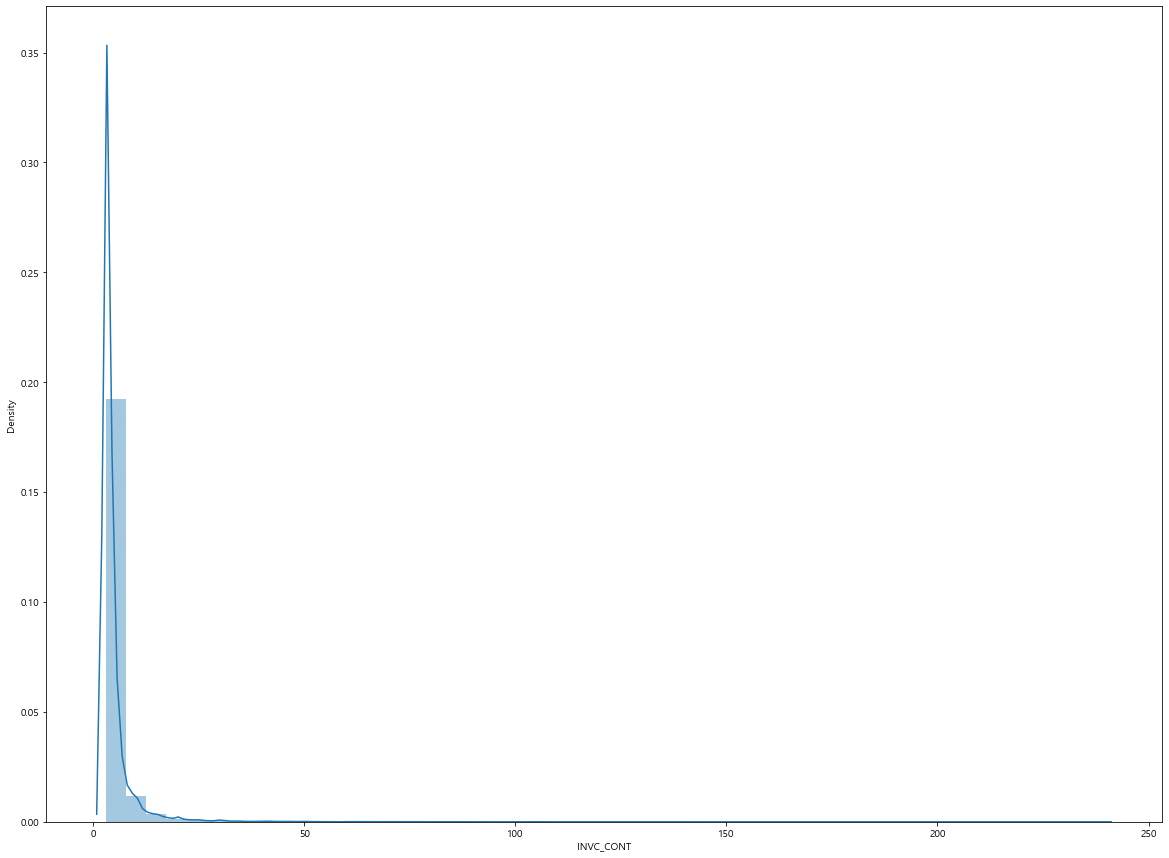

In [9]:
for col in train_df.columns[3:]:
    print('-' * 50)
    print('col : ', col)
    
    f, ax = plt.subplots(figsize=(20, 15))
    if col == 'INVC_CONT':
        sns.distplot(train_df[col])
    else:
        sns.countplot(x=col, data=train_df, alpha=0.5)
    plt.show()

In [10]:
train_df.describe()

,index,SEND_SPG_INNB,REC_SPG_INNB,INVC_CONT
count,32000.000000,3.200000e+04,3.200000e+04,32000.000000
mean,15999.500000,4.729981e+15,3.713145e+15,4.767875
std,9237.748643,7.387137e+14,1.320619e+15,5.752122
min,0.000000,1.111000e+15,1.111000e+15,3.000000
25%,7999.750000,5.011000e+15,2.820000e+15,3.000000
50%,15999.500000,5.011000e+15,4.146500e+15,3.000000
75%,23999.250000,5.013001e+15,4.812350e+15,5.000000
max,31999.000000,5.013001e+15,5.013001e+15,239.000000


In [11]:
train_df.groupby('DL_GD_LCLS_NM').agg('mean').sort_values(by='INVC_CONT', ascending=False)

,index,SEND_SPG_INNB,REC_SPG_INNB,INVC_CONT
DL_GD_LCLS_NM,,,,
패션의류,16413.115120,3.582663e+15,4.666343e+15,6.678694
디지털/가전,15752.066390,2.062064e+15,4.846556e+15,6.547718
생활/건강,15689.961386,4.106135e+15,4.360436e+15,5.407921
여행/문화,16481.989933,3.888472e+15,4.949955e+15,4.958893
화장품/미용,15007.339207,3.818801e+15,4.898578e+15,4.682819
식품,16002.898515,4.866285e+15,3.573308e+15,4.658195


In [12]:
train_df.groupby(['DL_GD_LCLS_NM', 'DL_GD_MCLS_NM']).agg('mean').sort_values(by='INVC_CONT', ascending=False)

index  SEND_SPG_INNB  REC_SPG_INNB  \
DL_GD_LCLS_NM DL_GD_MCLS_NM                                              
패션의류          기타패션의류         16186.363985   3.945157e+15  4.332316e+15   
생활/건강         건강용품           15901.460227   3.879239e+15  5.007309e+15   
식품            축산             15975.253589   4.612878e+15  3.637542e+15   
생활/건강         문구/사무용품        16068.016667   3.554040e+15  4.878931e+15   
식품            가공식품           15897.940412   3.891328e+15  4.660252e+15   
디지털/가전        기타디지털/가전       15752.066390   2.062064e+15  4.846556e+15   
식품            기타식품           15647.365535   4.436752e+15  4.115230e+15   
              건강식품           15336.453149   3.888268e+15  4.774279e+15   
              과자             16009.459770   4.379035e+15  4.312093e+15   
              음료             16257.595027   4.540800e+15  4.084283e+15   
              수산             16017.843179   4.893076e+15  3.706718e+15   
생활/건강         주방용품           15723.161585   3.843646e+15  4.966169e+15   
식품            냉동/간편조리식품      15598.799031   4.113526e+15  4.604564e+15   
여행/문화         문화컨텐츠          16481.989933   3.888472e+15  4.949955e+15   
생활/건강         생활용품           15765.008746   3.762116e+15  4.962372e+15   
화장품/미용        스킨케어           15007.339207   3.818801e+15  4.898578e+15   
생활/건강         반려동물           15706.997207   3.795453e+15  4.993182e+15   
식품            농산물            16033.515522   4.992335e+15  3.410434e+15   
생활/건강         음반             15456.885039   4.822089e+15  3.039420e+15   
패션의류          상의             16597.482866   3.287925e+15  4.937936e+15   

                             INVC_CONT  
DL_GD_LCLS_NM DL_GD_MCLS_NM             
패션의류          기타패션의류         10.375479  
생활/건강         건강용품           10.238636  
식품            축산              8.196172  
생활/건강         문구/사무용품         7.900000  
식품            가공식품            6.807151  
디지털/가전        기타디지털/가전        6.547718  
식품            기타식품            6.130548  
              건강식품            5.780338  
              과자              5.767241  
              음료              5.745115  
              수산              5.647691  
생활/건강         주방용품            5.634146  
식품            냉동/간편조리식품       5.007264  
여행/문화         문화컨텐츠           4.958893  
생활/건강         생활용품            4.918367  
화장품/미용        스킨케어            4.682819  
생활/건강         반려동물            4.444134  
식품            농산물             4.297401  
생활/건강         음반              4.053543  
패션의류          상의              3.672897

#### 데이터 전처리

In [13]:
# index 삭제
train = train_df.drop('index', axis=1)
test = test_df.drop('index', axis=1)

In [14]:
# target encoding -> 오히려 rmse 증가..
'''
invc_cont_avg = train[['DL_GD_LCLS_NM', 'DL_GD_MCLS_NM', 'INVC_CONT']]\
                      .groupby(['DL_GD_LCLS_NM', 'DL_GD_MCLS_NM'])\
                      .agg('mean').reset_index()
invc_cont_avg.columns = ['DL_GD_LCLS_NM_temp', 'DL_GD_MCLS_NM_temp', 'INVC_CONT_AVG']

train = train.merge(invc_cont_avg, left_on=['DL_GD_LCLS_NM', 'DL_GD_MCLS_NM'], 
                    right_on=['DL_GD_LCLS_NM_temp', 'DL_GD_MCLS_NM_temp'], how='inner')
train.drop(['DL_GD_LCLS_NM_temp', 'DL_GD_MCLS_NM_temp'], axis=1, inplace=True)
test = test.merge(invc_cont_avg, left_on=['DL_GD_LCLS_NM', 'DL_GD_MCLS_NM'],
                 right_on=['DL_GD_LCLS_NM_temp', 'DL_GD_MCLS_NM_temp'], how='inner')
test.drop(['DL_GD_LCLS_NM_temp', 'DL_GD_MCLS_NM_temp'], axis=1, inplace=True)
train.head()
'''

"\ninvc_cont_avg = train[['DL_GD_LCLS_NM', 'DL_GD_MCLS_NM', 'INVC_CONT']]                      .groupby(['DL_GD_LCLS_NM', 'DL_GD_MCLS_NM'])                      .agg('mean').reset_index()\ninvc_cont_avg.columns = ['DL_GD_LCLS_NM_temp', 'DL_GD_MCLS_NM_temp', 'INVC_CONT_AVG']\n\ntrain = train.merge(invc_cont_avg, left_on=['DL_GD_LCLS_NM', 'DL_GD_MCLS_NM'], \n                    right_on=['DL_GD_LCLS_NM_temp', 'DL_GD_MCLS_NM_temp'], how='inner')\ntrain.drop(['DL_GD_LCLS_NM_temp', 'DL_GD_MCLS_NM_temp'], axis=1, inplace=True)\ntest = test.merge(invc_cont_avg, left_on=['DL_GD_LCLS_NM', 'DL_GD_MCLS_NM'],\n                 right_on=['DL_GD_LCLS_NM_temp', 'DL_GD_MCLS_NM_temp'], how='inner')\ntest.drop(['DL_GD_LCLS_NM_temp', 'DL_GD_MCLS_NM_temp'], axis=1, inplace=True)\ntrain.head()\n"

In [15]:
# SEND_SPG_INNB, REC_SPG_INNB 앞 4자리만 따기
train.SEND_SPG_INNB = train.SEND_SPG_INNB.apply(lambda x: int(str(x)[:4]))
train.REC_SPG_INNB = train.REC_SPG_INNB.apply(lambda x: int(str(x)[:4]))

test.SEND_SPG_INNB = test.SEND_SPG_INNB.apply(lambda x: int(str(x)[:4]))
test.REC_SPG_INNB = test.REC_SPG_INNB.apply(lambda x: int(str(x)[:4]))

In [16]:
# [v] SEND_SPG_INNB, REC_SPG_INNB 합친 문자열 개수 -> 숫자로 자주 이동하는 경로 여부 파악 => 개선 X
# [v] SEND_SPG_INNB, REC_SPG_INNB 합친 문자열 개수 -> n등분해서 범주형으로 변환 후 적용 => 개선 X
'''
t1 = (train.SEND_SPG_INNB.astype(str) + '_' + train.REC_SPG_INNB.astype(str)).value_counts()
t2 = (test.SEND_SPG_INNB.astype(str) + '_' + test.REC_SPG_INNB.astype(str)).value_counts()

print(t1.shape[0], t2.shape[0])
t = pd.DataFrame(t1.add(t2, fill_value=0))
t = t.reset_index()
t.columns = ['SPG_INNB_t', 'cnt']
t.cnt = t.cnt.astype(int)
t.cnt = pd.qcut(t.cnt, 5, labels=[1, 2, 3, 4, 5])

train['SPG_INNB'] = train.SEND_SPG_INNB.astype(str) + '_' + train.REC_SPG_INNB.astype(str)
test['SPG_INNB'] = test.SEND_SPG_INNB.astype(str) + '_' + test.REC_SPG_INNB.astype(str)

train = train.merge(t, left_on=['SPG_INNB'], right_on=['SPG_INNB_t'])
train.drop(['SPG_INNB', 'SPG_INNB_t'], axis=1, inplace=True)

test = test.merge(t, left_on=['SPG_INNB'], right_on=['SPG_INNB_t'])
test.drop(['SPG_INNB', 'SPG_INNB_t'], axis=1, inplace=True)

train.head()
'''

"\nt1 = (train.SEND_SPG_INNB.astype(str) + '_' + train.REC_SPG_INNB.astype(str)).value_counts()\nt2 = (test.SEND_SPG_INNB.astype(str) + '_' + test.REC_SPG_INNB.astype(str)).value_counts()\n\nprint(t1.shape[0], t2.shape[0])\nt = pd.DataFrame(t1.add(t2, fill_value=0))\nt = t.reset_index()\nt.columns = ['SPG_INNB_t', 'cnt']\nt.cnt = t.cnt.astype(int)\nt.cnt = pd.qcut(t.cnt, 5, labels=[1, 2, 3, 4, 5])\n\ntrain['SPG_INNB'] = train.SEND_SPG_INNB.astype(str) + '_' + train.REC_SPG_INNB.astype(str)\ntest['SPG_INNB'] = test.SEND_SPG_INNB.astype(str) + '_' + test.REC_SPG_INNB.astype(str)\n\ntrain = train.merge(t, left_on=['SPG_INNB'], right_on=['SPG_INNB_t'])\ntrain.drop(['SPG_INNB', 'SPG_INNB_t'], axis=1, inplace=True)\n\ntest = test.merge(t, left_on=['SPG_INNB'], right_on=['SPG_INNB_t'])\ntest.drop(['SPG_INNB', 'SPG_INNB_t'], axis=1, inplace=True)\n\ntrain.head()\n"

In [17]:
# [] SEND_SPG_INNB, REC_SPG_INNB 합친 문자열 Encoding해서 사용하는 방안
# [v] SEND_SPG_INNB, REC_SPG_INNB 앞 4자리 뺀 숫자 사용 -> 효과 없음

In [18]:
scaler1 = MinMaxScaler()
scaler2 = MinMaxScaler()

# 표준화
train['SEND_SPG_INNB'] = scaler1.fit_transform(train[['SEND_SPG_INNB']])
train['REC_SPG_INNB'] = scaler2.fit_transform(train[['REC_SPG_INNB']])

test['SEND_SPG_INNB'] = scaler1.transform(test[['SEND_SPG_INNB']])
test['REC_SPG_INNB'] = scaler2.transform(test[['REC_SPG_INNB']])

In [19]:
# DL_GD_LCLS_NM (대분류) 삭제
train = train.drop('DL_GD_LCLS_NM', axis=1)
test = test.drop('DL_GD_LCLS_NM', axis=1)

In [20]:
# 원핫 인코딩
train_one = pd.get_dummies(train)
test_one = pd.get_dummies(test)

In [21]:
train_one

,SEND_SPG_INNB,REC_SPG_INNB,INVC_CONT,DL_GD_MCLS_NM_가공식품,DL_GD_MCLS_NM_건강식품,DL_GD_MCLS_NM_건강용품,DL_GD_MCLS_NM_과자,DL_GD_MCLS_NM_기타디지털/가전,DL_GD_MCLS_NM_기타식품,DL_GD_MCLS_NM_기타패션의류,...,DL_GD_MCLS_NM_문화컨텐츠,DL_GD_MCLS_NM_반려동물,DL_GD_MCLS_NM_상의,DL_GD_MCLS_NM_생활용품,DL_GD_MCLS_NM_수산,DL_GD_MCLS_NM_스킨케어,DL_GD_MCLS_NM_음료,DL_GD_MCLS_NM_음반,DL_GD_MCLS_NM_주방용품,DL_GD_MCLS_NM_축산
0,0.004613,0.999487,3,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0.006151,0.999487,3,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0.006151,0.999487,9,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0.011020,0.999487,10,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.013839,0.999487,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31995,0.999487,0.390569,6,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31996,0.999487,0.014608,5,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
31997,0.999487,0.770887,9,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31998,0.999487,0.005382,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 모델링

In [56]:
# LGBM 데이터 적은 경우 과적합 가능성. 다른 Regression 모델도 적용해 볼 것
# 전통 Regression 방식 추가
# LGBM + XGBOOST ensemble 적용 고려

train_X = train_one.drop('INVC_CONT',axis = 1)
train_Y = train_one['INVC_CONT']

In [23]:
# Parameters
grid_params = {
    'num_leaves': [7, 25, 50],
    'learning_rate': [0.1, 0.03, 0.003],
    'max_depth': [-1, 5, 10],
    'n_estimators': [50, 100, 200, 500],
}

# GridSearchCV 정의
grid = GridSearchCV(LGBMRegressor(random_state=0), grid_params, n_jobs=-1, scoring='neg_root_mean_squared_error', cv=5)

# GridSearchCV 학습
grid.fit(train_X, train_Y)

GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=0), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.03, 0.003],
                         'max_depth': [-1, 5, 10],
                         'n_estimators': [50, 100, 200, 500],
                         'num_leaves': [7, 25, 50]},
             scoring='neg_root_mean_squared_error')

In [24]:
abs(grid.best_score_)

5.399183227419973

In [25]:
grid.best_params_

{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100, 'num_leaves': 50}

In [26]:
model_grid = LGBMRegressor(**grid.best_params_)

# 모델 학습
model_grid.fit(train_X, train_Y)

# test 데이터 예측
pred_grid = model_grid.predict(test_one)

In [27]:
pred_grid

array([4.09951306, 4.12126421, 4.11111611, ..., 4.42241961, 4.15056263,
       4.35469932])

In [28]:
# Parameters
xgb_params = {
    'eta': [0.1, 0.03, 0.003],
    'max_depth': [-1, 5, 10],
    'subsample': [0.5, 0.75, 1],
}

# GridSearchCV 정의
xgb = GridSearchCV(XGBRegressor(random_state=0), xgb_params, n_jobs=-1, scoring='neg_root_mean_squared_error', cv=5)

# GridSearchCV 학습
xgb.fit(train_X, train_Y)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=0,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_paramet

In [29]:
abs(xgb.best_score_)

5.395056824402685

In [30]:
xgb.best_params_

{'eta': 0.03, 'max_depth': 5, 'subsample': 0.5}

In [31]:
model_xgb = XGBRegressor(**xgb.best_params_)

# 모델 학습
model_xgb.fit(train_X, train_Y)

# test 데이터 예측
pred_xgb = model_xgb.predict(test_one)

In [32]:
pred_xgb

array([3.9153545, 3.9063406, 3.9975572, ..., 4.3096814, 4.01623  ,
       4.0399146], dtype=float32)

In [60]:
elasticnet = ElasticNet()
alphas = np.logspace(-4, 0, 200)
parameters = {'alpha': alphas}

elastic = GridSearchCV(elasticnet, parameters, scoring='neg_root_mean_squared_error',cv=5)
elastic.fit(train_X, train_Y)

print(elastic.best_params_)
print(abs(elastic.best_score_))

C:\Users\donguk\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 185.8134204170201, tolerance: 86.57026405859374
  model = cd_fast.enet_coordinate_descent(
C:\Users\donguk\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1408.128616941045, tolerance: 85.07531093750002
  model = cd_fast.enet_coordinate_descent(
C:\Users\donguk\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 127.97037296136841, tolerance: 86.57026405859374
  model = cd_fast.enet_coordinate_descent(
C:\Users\donguk\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceW

{'alpha': 0.0016831803533309566}


NameError: name 'avg' is not defined

In [61]:
model_elasticnet = ElasticNet(**elastic.best_params_)

# 모델 학습
model_elasticnet.fit(train_X, train_Y)

# test 데이터 예측
pred_elastic = model_elasticnet.predict(test_one)

In [62]:
pred_elastic

array([4.03744331, 4.03614033, 4.38972065, ..., 4.41009446, 4.39043137,
       4.22092603])

In [35]:
train_X = train_X.to_numpy()
train_Y = train_Y.to_numpy().reshape(-1,1)
test_X = test_one.to_numpy()

In [37]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)
preds = []
scores  = []

for trn_idx,val_idx in kf.split(train_X):
    X_trn = train_X[trn_idx]
    y_trn = train_Y[trn_idx]
    X_val = train_X[val_idx]
    y_val = train_Y[val_idx]

    model = TabNetRegressor(verbose = 1,seed = 42,optimizer_fn=torch.optim.AdamW)
    model.fit(X_train=X_trn, y_train=y_trn,
              eval_set=[(X_val, y_val)],
            patience=100, max_epochs=2000,
              eval_metric=['rmse'])
    scores.append(model.best_cost)
    
    pred = model.predict(test_X)
    preds.append(pred)

print("CV 평균 점수 : %.5f" % np.mean(scores,axis=0) )

Device used : cpu
epoch 0  | loss: 37.65508| val_0_rmse: 6.07571 |  0:00:06s
epoch 1  | loss: 32.13071| val_0_rmse: 6.03651 |  0:00:12s
epoch 2  | loss: 32.10544| val_0_rmse: 6.01467 |  0:00:19s
epoch 3  | loss: 31.63848| val_0_rmse: 6.01924 |  0:00:25s
epoch 4  | loss: 31.71786| val_0_rmse: 6.0183  |  0:00:32s
epoch 5  | loss: 31.54261| val_0_rmse: 6.03236 |  0:00:38s
epoch 6  | loss: 31.55083| val_0_rmse: 6.02575 |  0:00:45s
epoch 7  | loss: 31.49391| val_0_rmse: 6.00338 |  0:00:51s
epoch 8  | loss: 31.57357| val_0_rmse: 6.01692 |  0:00:58s
epoch 9  | loss: 31.42167| val_0_rmse: 6.00629 |  0:01:05s
epoch 10 | loss: 31.32981| val_0_rmse: 5.99441 |  0:01:11s
epoch 11 | loss: 31.45919| val_0_rmse: 6.0008  |  0:01:18s
epoch 12 | loss: 31.47441| val_0_rmse: 6.0201  |  0:01:24s
epoch 13 | loss: 31.45396| val_0_rmse: 6.0147  |  0:01:31s
epoch 14 | loss: 31.51912| val_0_rmse: 5.99251 |  0:01:37s
epoch 15 | loss: 31.49162| val_0_rmse: 5.98911 |  0:01:44s
epoch 16 | loss: 31.47181| val_0_rmse:

epoch 139| loss: 30.7429 | val_0_rmse: 5.94973 |  0:09:57s
epoch 140| loss: 30.6335 | val_0_rmse: 5.94433 |  0:10:00s
epoch 141| loss: 30.74912| val_0_rmse: 6.10306 |  0:10:03s
epoch 142| loss: 30.66388| val_0_rmse: 5.94969 |  0:10:06s
epoch 143| loss: 30.77381| val_0_rmse: 5.95208 |  0:10:08s
epoch 144| loss: 30.72726| val_0_rmse: 5.96653 |  0:10:11s
epoch 145| loss: 30.63886| val_0_rmse: 5.99323 |  0:10:14s
epoch 146| loss: 30.80969| val_0_rmse: 5.96835 |  0:10:17s
epoch 147| loss: 30.62184| val_0_rmse: 5.94121 |  0:10:20s
epoch 148| loss: 30.66192| val_0_rmse: 5.96052 |  0:10:23s
epoch 149| loss: 30.74353| val_0_rmse: 5.94201 |  0:10:26s
epoch 150| loss: 30.77243| val_0_rmse: 5.96732 |  0:10:29s
epoch 151| loss: 30.824  | val_0_rmse: 5.96158 |  0:10:32s
epoch 152| loss: 30.85541| val_0_rmse: 5.96361 |  0:10:35s
epoch 153| loss: 30.78139| val_0_rmse: 5.99356 |  0:10:38s
epoch 154| loss: 30.82864| val_0_rmse: 5.963   |  0:10:41s
epoch 155| loss: 30.7016 | val_0_rmse: 5.98627 |  0:10:4

epoch 5  | loss: 32.10826| val_0_rmse: 5.81151 |  0:00:17s
epoch 6  | loss: 32.14265| val_0_rmse: 5.82435 |  0:00:20s
epoch 7  | loss: 32.10326| val_0_rmse: 5.82446 |  0:00:23s
epoch 8  | loss: 32.10185| val_0_rmse: 5.81541 |  0:00:26s
epoch 9  | loss: 32.03157| val_0_rmse: 5.80923 |  0:00:29s
epoch 10 | loss: 32.02617| val_0_rmse: 5.81856 |  0:00:32s
epoch 11 | loss: 32.05219| val_0_rmse: 5.80649 |  0:00:35s
epoch 12 | loss: 32.03246| val_0_rmse: 5.8162  |  0:00:38s
epoch 13 | loss: 32.06186| val_0_rmse: 5.81264 |  0:00:41s
epoch 14 | loss: 32.14777| val_0_rmse: 5.81625 |  0:00:44s
epoch 15 | loss: 32.00108| val_0_rmse: 5.7956  |  0:00:47s
epoch 16 | loss: 31.96939| val_0_rmse: 5.7852  |  0:00:50s
epoch 17 | loss: 32.02572| val_0_rmse: 5.80336 |  0:00:53s
epoch 18 | loss: 31.96465| val_0_rmse: 5.79632 |  0:00:56s
epoch 19 | loss: 31.88225| val_0_rmse: 5.79282 |  0:00:59s
epoch 20 | loss: 32.01539| val_0_rmse: 5.81093 |  0:01:02s
epoch 21 | loss: 31.93804| val_0_rmse: 5.79599 |  0:01:0

epoch 144| loss: 31.55591| val_0_rmse: 5.74501 |  0:07:11s
epoch 145| loss: 31.5116 | val_0_rmse: 5.74374 |  0:07:14s
epoch 146| loss: 31.51699| val_0_rmse: 5.76313 |  0:07:17s
epoch 147| loss: 31.56869| val_0_rmse: 5.78328 |  0:07:20s
epoch 148| loss: 31.58052| val_0_rmse: 5.73977 |  0:07:23s
epoch 149| loss: 31.49769| val_0_rmse: 5.74993 |  0:07:26s
epoch 150| loss: 31.61332| val_0_rmse: 5.75987 |  0:07:28s
epoch 151| loss: 31.4903 | val_0_rmse: 5.76448 |  0:07:31s
epoch 152| loss: 31.45337| val_0_rmse: 5.74659 |  0:07:35s
epoch 153| loss: 31.41376| val_0_rmse: 5.77627 |  0:07:38s
epoch 154| loss: 31.96176| val_0_rmse: 5.75703 |  0:07:41s
epoch 155| loss: 31.69379| val_0_rmse: 5.7914  |  0:07:44s
epoch 156| loss: 31.65939| val_0_rmse: 5.77364 |  0:07:47s
epoch 157| loss: 31.6375 | val_0_rmse: 5.75626 |  0:07:50s
epoch 158| loss: 31.65026| val_0_rmse: 5.75154 |  0:07:53s
epoch 159| loss: 31.53483| val_0_rmse: 5.73934 |  0:07:55s
epoch 160| loss: 31.52298| val_0_rmse: 5.74314 |  0:07:5

epoch 283| loss: 31.36063| val_0_rmse: 5.73654 |  0:14:05s
epoch 284| loss: 31.36494| val_0_rmse: 5.72707 |  0:14:08s
epoch 285| loss: 31.3076 | val_0_rmse: 5.76651 |  0:14:10s
epoch 286| loss: 31.1044 | val_0_rmse: 5.79252 |  0:14:13s
epoch 287| loss: 31.59868| val_0_rmse: 5.72744 |  0:14:16s
epoch 288| loss: 31.36048| val_0_rmse: 5.76127 |  0:14:19s
epoch 289| loss: 31.37312| val_0_rmse: 5.73976 |  0:14:22s
epoch 290| loss: 31.40688| val_0_rmse: 5.72388 |  0:14:25s
epoch 291| loss: 31.15291| val_0_rmse: 5.74092 |  0:14:28s
epoch 292| loss: 31.31133| val_0_rmse: 5.72955 |  0:14:31s
epoch 293| loss: 31.26511| val_0_rmse: 5.74397 |  0:14:34s
epoch 294| loss: 31.24833| val_0_rmse: 5.73582 |  0:14:37s
epoch 295| loss: 31.3411 | val_0_rmse: 5.73345 |  0:14:40s
epoch 296| loss: 31.27214| val_0_rmse: 5.72721 |  0:14:43s
epoch 297| loss: 31.23589| val_0_rmse: 5.73899 |  0:14:46s
epoch 298| loss: 31.28589| val_0_rmse: 5.72089 |  0:14:49s
epoch 299| loss: 31.28136| val_0_rmse: 5.73153 |  0:14:5

epoch 5  | loss: 33.093  | val_0_rmse: 5.401   |  0:00:17s
epoch 6  | loss: 33.21052| val_0_rmse: 5.4205  |  0:00:20s
epoch 7  | loss: 33.2849 | val_0_rmse: 5.40368 |  0:00:23s
epoch 8  | loss: 33.07322| val_0_rmse: 5.37779 |  0:00:26s
epoch 9  | loss: 33.00492| val_0_rmse: 5.38837 |  0:00:29s
epoch 10 | loss: 33.00741| val_0_rmse: 5.3768  |  0:00:31s
epoch 11 | loss: 33.01165| val_0_rmse: 5.40086 |  0:00:34s
epoch 12 | loss: 33.04602| val_0_rmse: 5.37792 |  0:00:37s
epoch 13 | loss: 33.07666| val_0_rmse: 5.41473 |  0:00:40s
epoch 14 | loss: 33.21897| val_0_rmse: 5.38957 |  0:00:43s
epoch 15 | loss: 33.32412| val_0_rmse: 5.394   |  0:00:46s
epoch 16 | loss: 33.23218| val_0_rmse: 5.39022 |  0:00:49s
epoch 17 | loss: 33.11774| val_0_rmse: 5.39327 |  0:00:52s
epoch 18 | loss: 33.16231| val_0_rmse: 5.37506 |  0:00:55s
epoch 19 | loss: 33.08671| val_0_rmse: 5.37874 |  0:00:57s
epoch 20 | loss: 33.07459| val_0_rmse: 5.39972 |  0:01:00s
epoch 21 | loss: 33.18876| val_0_rmse: 5.38651 |  0:01:0

epoch 144| loss: 32.58523| val_0_rmse: 5.34487 |  0:07:03s
epoch 145| loss: 32.56606| val_0_rmse: 5.33123 |  0:07:06s
epoch 146| loss: 32.51078| val_0_rmse: 5.34361 |  0:07:09s
epoch 147| loss: 32.57606| val_0_rmse: 5.32797 |  0:07:12s
epoch 148| loss: 32.58673| val_0_rmse: 5.34648 |  0:07:15s
epoch 149| loss: 32.69474| val_0_rmse: 5.33767 |  0:07:17s
epoch 150| loss: 32.60869| val_0_rmse: 5.34375 |  0:07:20s
epoch 151| loss: 32.55888| val_0_rmse: 5.32453 |  0:07:24s
epoch 152| loss: 32.62963| val_0_rmse: 5.33519 |  0:07:27s
epoch 153| loss: 32.53751| val_0_rmse: 5.31356 |  0:07:30s
epoch 154| loss: 32.50361| val_0_rmse: 5.37011 |  0:07:32s
epoch 155| loss: 32.67133| val_0_rmse: 5.34932 |  0:07:35s
epoch 156| loss: 32.62931| val_0_rmse: 5.36049 |  0:07:38s
epoch 157| loss: 32.71645| val_0_rmse: 5.33884 |  0:07:41s
epoch 158| loss: 32.63048| val_0_rmse: 5.33637 |  0:07:44s
epoch 159| loss: 32.61234| val_0_rmse: 5.33373 |  0:07:47s
epoch 160| loss: 32.51577| val_0_rmse: 5.33113 |  0:07:5

epoch 283| loss: 32.49429| val_0_rmse: 5.34143 |  0:13:48s
epoch 284| loss: 32.52309| val_0_rmse: 5.33882 |  0:13:51s
epoch 285| loss: 32.36248| val_0_rmse: 5.34675 |  0:13:54s
epoch 286| loss: 32.50963| val_0_rmse: 5.33179 |  0:13:57s
epoch 287| loss: 32.23686| val_0_rmse: 5.33797 |  0:14:00s
epoch 288| loss: 32.44591| val_0_rmse: 5.3388  |  0:14:03s
epoch 289| loss: 32.46845| val_0_rmse: 5.35822 |  0:14:06s
epoch 290| loss: 32.45108| val_0_rmse: 5.32634 |  0:14:09s
epoch 291| loss: 32.37629| val_0_rmse: 5.3081  |  0:14:12s
epoch 292| loss: 32.493  | val_0_rmse: 5.31821 |  0:14:14s
epoch 293| loss: 32.52935| val_0_rmse: 5.36    |  0:14:17s
epoch 294| loss: 32.48355| val_0_rmse: 5.32721 |  0:14:20s
epoch 295| loss: 32.38693| val_0_rmse: 5.33845 |  0:14:23s
epoch 296| loss: 32.48321| val_0_rmse: 5.35444 |  0:14:26s
epoch 297| loss: 32.66579| val_0_rmse: 5.34505 |  0:14:29s
epoch 298| loss: 32.41971| val_0_rmse: 5.34181 |  0:14:32s
epoch 299| loss: 32.34499| val_0_rmse: 5.32576 |  0:14:3

epoch 91 | loss: 29.75187| val_0_rmse: 6.33708 |  0:03:57s
epoch 92 | loss: 29.77733| val_0_rmse: 6.33583 |  0:04:00s
epoch 93 | loss: 29.78648| val_0_rmse: 6.3413  |  0:04:03s
epoch 94 | loss: 29.84536| val_0_rmse: 6.34389 |  0:04:05s
epoch 95 | loss: 29.98992| val_0_rmse: 6.344   |  0:04:08s
epoch 96 | loss: 29.75726| val_0_rmse: 6.33728 |  0:04:11s
epoch 97 | loss: 29.81815| val_0_rmse: 6.34601 |  0:04:13s
epoch 98 | loss: 29.77233| val_0_rmse: 6.33882 |  0:04:16s
epoch 99 | loss: 29.7748 | val_0_rmse: 6.34448 |  0:04:18s
epoch 100| loss: 29.79799| val_0_rmse: 6.33883 |  0:04:21s
epoch 101| loss: 29.70263| val_0_rmse: 6.33273 |  0:04:23s
epoch 102| loss: 29.78618| val_0_rmse: 6.34566 |  0:04:26s
epoch 103| loss: 29.77312| val_0_rmse: 6.33448 |  0:04:29s
epoch 104| loss: 29.84633| val_0_rmse: 6.34266 |  0:04:31s
epoch 105| loss: 29.86548| val_0_rmse: 6.35059 |  0:04:34s
epoch 106| loss: 29.94982| val_0_rmse: 6.3639  |  0:04:36s
epoch 107| loss: 29.99241| val_0_rmse: 6.35136 |  0:04:3

epoch 230| loss: 29.55311| val_0_rmse: 6.31228 |  0:10:35s
epoch 231| loss: 29.67308| val_0_rmse: 6.31313 |  0:10:38s
epoch 232| loss: 29.54351| val_0_rmse: 6.31714 |  0:10:41s
epoch 233| loss: 29.53814| val_0_rmse: 6.31133 |  0:10:43s
epoch 234| loss: 29.55822| val_0_rmse: 6.3217  |  0:10:46s
epoch 235| loss: 29.47222| val_0_rmse: 6.32002 |  0:10:49s
epoch 236| loss: 29.55073| val_0_rmse: 6.33958 |  0:10:52s
epoch 237| loss: 29.6439 | val_0_rmse: 6.32862 |  0:10:55s
epoch 238| loss: 29.57271| val_0_rmse: 6.31931 |  0:10:58s
epoch 239| loss: 29.60828| val_0_rmse: 6.32875 |  0:11:01s
epoch 240| loss: 29.66527| val_0_rmse: 6.32858 |  0:11:04s
epoch 241| loss: 29.57774| val_0_rmse: 6.32525 |  0:11:07s
epoch 242| loss: 29.60717| val_0_rmse: 6.33449 |  0:11:09s
epoch 243| loss: 29.49812| val_0_rmse: 6.31462 |  0:11:12s
epoch 244| loss: 29.32685| val_0_rmse: 6.32888 |  0:11:15s
epoch 245| loss: 29.61017| val_0_rmse: 6.33481 |  0:11:18s
epoch 246| loss: 29.50914| val_0_rmse: 6.39335 |  0:11:2

epoch 369| loss: 29.55318| val_0_rmse: 6.31038 |  0:17:18s
epoch 370| loss: 29.55036| val_0_rmse: 6.33301 |  0:17:21s
epoch 371| loss: 29.33844| val_0_rmse: 6.33607 |  0:17:24s
epoch 372| loss: 29.54304| val_0_rmse: 6.31882 |  0:17:26s
epoch 373| loss: 29.73475| val_0_rmse: 6.32542 |  0:17:29s
epoch 374| loss: 29.55362| val_0_rmse: 6.31577 |  0:17:32s
epoch 375| loss: 29.40463| val_0_rmse: 6.3192  |  0:17:35s
epoch 376| loss: 29.45196| val_0_rmse: 6.32146 |  0:17:38s
epoch 377| loss: 29.47066| val_0_rmse: 6.32223 |  0:17:41s
epoch 378| loss: 29.35135| val_0_rmse: 6.32304 |  0:17:44s
epoch 379| loss: 29.48226| val_0_rmse: 6.32414 |  0:17:46s
epoch 380| loss: 29.47166| val_0_rmse: 6.32596 |  0:17:49s
epoch 381| loss: 29.35937| val_0_rmse: 6.31469 |  0:17:52s
epoch 382| loss: 29.40261| val_0_rmse: 6.31993 |  0:17:55s
epoch 383| loss: 29.4879 | val_0_rmse: 6.31524 |  0:17:58s
epoch 384| loss: 29.41995| val_0_rmse: 6.32821 |  0:18:01s
epoch 385| loss: 29.35306| val_0_rmse: 6.31295 |  0:18:0

Device used : cpu
epoch 0  | loss: 41.7292 | val_0_rmse: 4.81658 |  0:00:02s
epoch 1  | loss: 35.53169| val_0_rmse: 4.79132 |  0:00:05s
epoch 2  | loss: 35.2678 | val_0_rmse: 4.80923 |  0:00:08s
epoch 3  | loss: 35.03526| val_0_rmse: 4.78563 |  0:00:11s
epoch 4  | loss: 35.00389| val_0_rmse: 4.79818 |  0:00:14s
epoch 5  | loss: 35.03508| val_0_rmse: 4.78907 |  0:00:17s
epoch 6  | loss: 34.95723| val_0_rmse: 4.78833 |  0:00:20s
epoch 7  | loss: 34.82985| val_0_rmse: 4.78983 |  0:00:23s
epoch 8  | loss: 34.86085| val_0_rmse: 4.78469 |  0:00:26s
epoch 9  | loss: 34.85641| val_0_rmse: 4.77326 |  0:00:29s
epoch 10 | loss: 34.86695| val_0_rmse: 4.78599 |  0:00:31s
epoch 11 | loss: 34.75739| val_0_rmse: 4.7602  |  0:00:34s
epoch 12 | loss: 34.76033| val_0_rmse: 4.74591 |  0:00:37s
epoch 13 | loss: 34.78565| val_0_rmse: 4.75233 |  0:00:40s
epoch 14 | loss: 34.72393| val_0_rmse: 4.72719 |  0:00:43s
epoch 15 | loss: 34.66431| val_0_rmse: 4.74144 |  0:00:46s
epoch 16 | loss: 34.72786| val_0_rmse:

epoch 139| loss: 34.52508| val_0_rmse: 4.75103 |  0:06:46s
epoch 140| loss: 34.36201| val_0_rmse: 4.74012 |  0:06:49s
epoch 141| loss: 34.17789| val_0_rmse: 4.73049 |  0:06:51s
epoch 142| loss: 34.22905| val_0_rmse: 4.73759 |  0:06:54s
epoch 143| loss: 34.1272 | val_0_rmse: 4.73149 |  0:06:57s
epoch 144| loss: 34.09498| val_0_rmse: 4.75487 |  0:07:00s
epoch 145| loss: 34.0935 | val_0_rmse: 4.73135 |  0:07:03s
epoch 146| loss: 34.32872| val_0_rmse: 4.76539 |  0:07:06s
epoch 147| loss: 34.18032| val_0_rmse: 4.72343 |  0:07:09s
epoch 148| loss: 34.18131| val_0_rmse: 4.74687 |  0:07:12s
epoch 149| loss: 34.00686| val_0_rmse: 4.7473  |  0:07:15s
epoch 150| loss: 33.96395| val_0_rmse: 4.73569 |  0:07:18s
epoch 151| loss: 33.88175| val_0_rmse: 4.73413 |  0:07:20s
epoch 152| loss: 34.02737| val_0_rmse: 4.73701 |  0:07:23s
epoch 153| loss: 34.07595| val_0_rmse: 4.7399  |  0:07:26s
epoch 154| loss: 34.01622| val_0_rmse: 4.73873 |  0:07:29s
epoch 155| loss: 33.84863| val_0_rmse: 4.71617 |  0:07:3

In [50]:
tabnet_pred = np.mean(preds,axis = 0)
tabnet_pred = tabnet_pred.reshape(1, -1)[0]
tabnet_pred

array([4.0723267, 4.0713043, 4.281379 , ..., 4.3503737, 4.2835793,
       4.1940126], dtype=float32)

In [93]:
pred = pred_grid*0.3 + pred_xgb*0.7
pred

array([3.9521863 , 3.94932532, 4.02026895, ..., 4.33222901, 4.04309661,
       4.10287155])

### 정답파일 생성

In [94]:
submission['INVC_CONT'] = pred

In [95]:
submission.to_csv('result.csv',index = False)